

##### Copyright 2020 DeepMind Technologies Limited.

```
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
```

In [52]:
#@title Util functions

import csv
import os
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow.compat.v1 as tf
from tensorflow.compat.v1.io import gfile


def read_csv_as_dataframe(path):
  with gfile.GFile(path, "r") as file:
    reader = csv.reader(file, delimiter=" ")
    rows = [row for row in reader]
    rows[1:] = [[float(v) for v in row] for row in rows[1:]]
    cols = rows[0]
    rows = dict(zip(cols, (zip(*rows[1:]))))

  return pd.DataFrame(rows)


def read_data(path, num_seeds, verbose=False):
  all_dfs = []
  for seed in range(num_seeds):
    seed_path = path.format(seed)
    if verbose:
      print(f"Reading {seed_path}")
    df = read_csv_as_dataframe(seed_path)
    df["seed"] = seed 
    all_dfs.append(df)
  return pd.concat(all_dfs)

In [ ]:
#@title Unpack precomputed training curves
!wget -q --no-check-certificate https://storage.googleapis.com/option_keyboard/gpe_gpi_experiments.zip -P -O /tmp
!unzip -o /tmp/gpe_gpi_experiments.zip -d /tmp
DATA_DIR = "/tmp"

# Figure 4b

To generate the q-learning results:
```
python3 ../run_dqn.py --num_episodes=20000 --report_every=5 --output_path=/tmp/fig4_dqn.csv
```

To generate the regressed w results:
```
python3 train_keybooard.py --num_pretrain_episodes=20000 --policy_weights_name=12 --export_path=/tmp/fig4_keyboard
python3 run_regressed_w_fig4b.py --num_episodes=4000 --report_every=5 --keyboard_path=/tmp/fig6_keyboard/tfhub \
  --output_path=/tmp/fig4b_regressed_w.csv
```

To generate the results with true w:
```
# Make use of a pretrained keyboard.
python3 run_true_w_fig4.py --num_episodes=1000 --keyboard_path=/tmp/fig4_keyboard/tfhub -- output_path=/tmp/fig4b_true_w.csv
```

Repeat the above steps for multiple runs. Below shows the results for 10 runs.

In [54]:
#@title Load Data

dqn_path = os.path.join(DATA_DIR, "fig4_dqn_{}.csv")
dqn_df = read_data(dqn_path, num_seeds=10)
dqn_df["method"] = "Q-Learning"

regressed_w_path = os.path.join(DATA_DIR, "fig4_regressed_w_{}.csv")
regressed_w_df = read_data(regressed_w_path, num_seeds=10)
regressed_w_df["method"] = "GPE+GPI with regressed w"

true_w_path = os.path.join(DATA_DIR, "fig4_true_w_{}.csv")
true_w_df = read_data(true_w_path, num_seeds=10)
true_w_df["method"] = "GPE+GPI with true w"

fig4b_df = pd.concat([dqn_df, regressed_w_df])

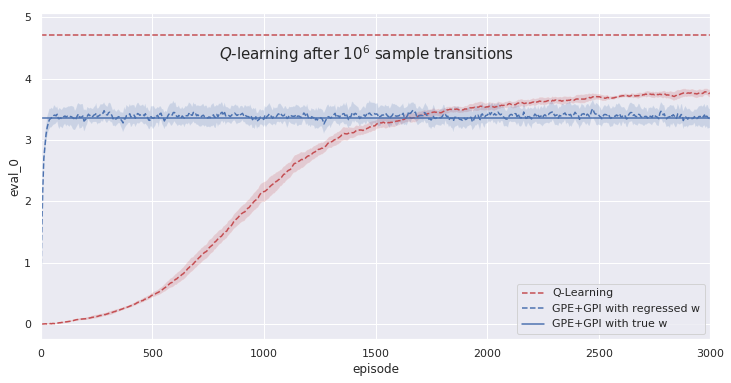

In [55]:
#@title Plot

fig, ax = plt.subplots(figsize=(12,6))
sns.tsplot(fig4b_df, time="episode", unit="seed", value="eval_0", condition="method", ci=95, color=["r", "b"], linestyle="--", ax=ax)

ax.axhline(dqn_df.groupby("seed").tail(1).mean()["eval_0"], color='r', linestyle='--')
ax.axhline(true_w_df.mean()["return"], color='b', linestyle='-', label="GPE+GPI with true w")

ax.text(
    800,
    4.3,
    r"$Q$-learning after $10^6$ sample transitions",
    fontdict=dict(fontsize=15))

ax.set_xlim([0, 3000])
ax.legend();

# Figure 4c

To generate the regressed w results:
```
python3 train_keybooard.py --num_pretrain_episodes=20000 --policy_weights_name=12 --export_path=/tmp/fig4_keyboard
python3 run_regressed_w_fig4c.py --num_episodes=100 --report_every=1 --keyboard_path=/tmp/fig6_keyboard/tfhub \
  --output_path=/tmp/fig4b_regressed_w.csv
```

To generate the regressed w with learned phi results:
```
# First train a phi model. Change num_phis to phi of different dimensions e.g. 3 or 4.
python3 train_phi_model.py --export_path=/tmp/phi_model_2d --num_phis=2
# Then train a keyboard.
python3 train_keybooard_with_phi.py --num_pretrain_episodes=20000 --phi_model_phi=/tmp/phi_model_2d \
  --export_path=/tmp/fig4_keyboard_with_phi
# Finally regress w with both models.
python3 run_regressed_w_with_phi_fig4c.py --num_episodes=100 --report_every=1 --keyboard_path=/tmp/fig4_keyboard_with_phi/tfhub \
  --output_path=/tmp/fig4c_regressed_w.csv
```

(Note that training of the phi model can converge to a poor local minima, so it maybe necessary to rerun it if the eval loss is too high, or use a larger set of random training tasks.)

Repeat the above steps for multiple runs. Below shows the results for 10 runs.

In [56]:
#@title Load Data

dqn_path = os.path.join(DATA_DIR, "fig4_dqn_{}.csv")
dqn_df = read_data(dqn_path, num_seeds=10)
dqn_df["method"] = "Q-Learning"

true_w_path = os.path.join(DATA_DIR, "fig4_true_w_{}.csv")
true_w_df = read_data(true_w_path, num_seeds=10)
true_w_df["method"] = "GPE+GPI with true w"

regressed_w_path = os.path.join(DATA_DIR, "fig4c_regressed_w_{}.csv")
regressed_w_df = read_data(regressed_w_path, num_seeds=10)
regressed_w_df["method"] = "GPE+GPI with regressed w"

regressed_w_with_phi_2d_path = os.path.join(DATA_DIR, "fig4c_regressed_w_with_phi_{}_2d.csv")
regressed_w_with_phi_2d_df = read_data(regressed_w_with_phi_2d_path, num_seeds=10)
regressed_w_with_phi_2d_df["method"] = "GPE+GPI with regressed w and 2d phi"

regressed_w_with_phi_3d_path = os.path.join(DATA_DIR, "fig4c_regressed_w_with_phi_{}_3d.csv")
regressed_w_with_phi_3d_df = read_data(regressed_w_with_phi_3d_path, num_seeds=10)
regressed_w_with_phi_3d_df["method"] = "GPE+GPI with regressed w and 3d phi"

regressed_w_with_phi_4d_path = os.path.join(DATA_DIR, "fig4c_regressed_w_with_phi_{}_4d.csv")
regressed_w_with_phi_4d_df = read_data(regressed_w_with_phi_4d_path, num_seeds=10)
regressed_w_with_phi_4d_df["method"] = "GPE+GPI with regressed w and 4d phi"

fig4c_df = pd.concat([regressed_w_df, regressed_w_with_phi_2d_df, regressed_w_with_phi_3d_df, regressed_w_with_phi_4d_df])

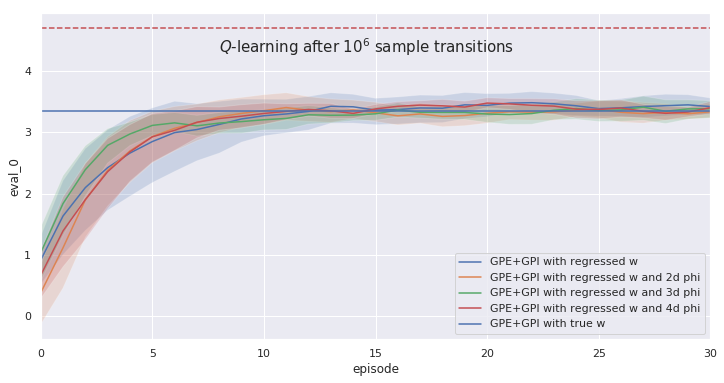

In [57]:
#@title Plot

fig, ax = plt.subplots(figsize=(12,6))
sns.tsplot(fig4c_df, time="episode", unit="seed", value="eval_0", condition="method", ci=95, ax=ax)

ax.axhline(dqn_df.groupby("seed").tail(1).mean()["eval_0"], color='r', linestyle='--')
ax.axhline(true_w_df.mean()["return"], color='b', linestyle='-', label="GPE+GPI with true w")

ax.text(
    8,
    4.3,
    r"$Q$-learning after $10^6$ sample transitions",
    fontdict=dict(fontsize=15))

ax.set_xlim([0, 30])
ax.legend();

# Figure 5a

To generate the result for each set of policies:

```
# Train a keyboard for a set of policies, i.e. replace {POLICY} with 5, 12 or 34
python3 train_keyboard.py --num_pretrain_episodes=20000 --policy_weights_name={POLICY} --export_path=/tmp/fig5a_keyboard_{POLICY}
# Evaluate the trained keyboard at regular interval between [-1, 0] to [0, -1]
python3 eval_keyboard_fig5.py --num_episodes=1000 --keyboard_paths=/tmp/fig5a_keyboard_{POLICY}/tfhub \
  --output_path=/tmp/fig5_polar_{POLICY}.csv
```

Repeat the above steps for multiple runs. Below shows the results for 10 runs.

In [58]:
#@title Load Data

policy_12_path = os.path.join(DATA_DIR, "fig5_polar_{}_12.csv")
policy_12_df = read_data(policy_12_path, num_seeds=10)
policy_34_path = os.path.join(DATA_DIR, "fig5_polar_{}_34.csv")
policy_34_df = read_data(policy_34_path, num_seeds=10)
policy_5_path = os.path.join(DATA_DIR, "fig5_polar_{}_5.csv")
policy_5_df = read_data(policy_5_path, num_seeds=10)

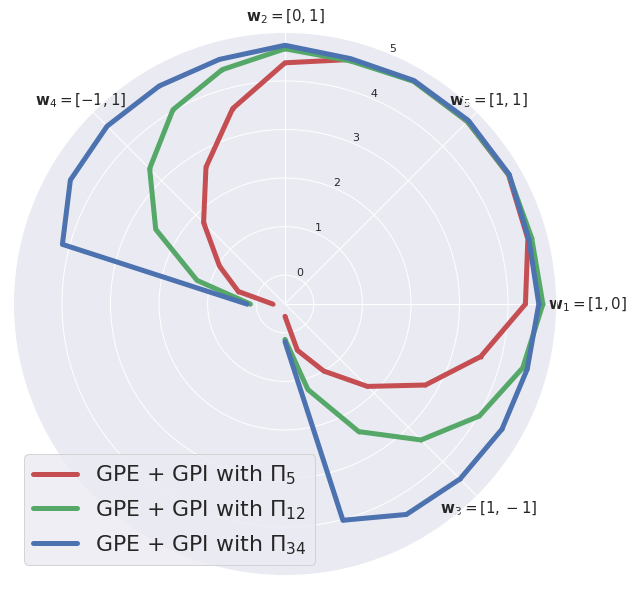

In [59]:
#@title Plot

use_polar = True
plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=use_polar)

policy_5_mean_df = policy_5_df.groupby("angle").mean()
ax.plot(
    policy_5_mean_df.index,
    policy_5_mean_df["return"],
    ".-",
    linewidth=5, color='r')

policy_12_mean_df = policy_12_df.groupby("angle").mean()
ax.plot(
    policy_12_mean_df.index,
    policy_12_mean_df["return"],
    ".-",
    linewidth=5, color='g')

policy_34_mean_df = policy_34_df.groupby("angle").mean()
ax.plot(
    policy_34_mean_df.index,
    policy_34_mean_df["return"],
    ".-",
    linewidth=5, color='b')

legend = ax.legend([
    r"GPE + GPI with $\Pi_{5}$", r"GPE + GPI with $\Pi_{12}$", r"GPE + GPI with $\Pi_{34}$",
    r"$Q$-learning"
],
                   fontsize="22",
                   loc="lower left")

ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

lines, labels = ax.set_thetagrids(
    (0, 45, 90, 135, 315),
    (r"$\mathbf{w}_2 = [0,1]$", r"$\mathbf{w}_5 = [1,1]$",
     r"$\qquad \mathbf{w}_1 = [1,0]$", r"$\mathbf{w}_3 = [1,-1]$",
     r"$\mathbf{w}_4 = [-1,1]$"),
    fontweight="bold",
    fontsize=15)

# Figure 5b

To generate the result for each set of policies:

```
# Train a keyboard for a set of policies, i.e. replace {POLICY} with 4, 42, 425, 4251 or 42513
python3 train_keyboard.py --num_pretrain_episodes=20000 --policy_weights_name={POLICY} --export_path=/tmp/fig5a_keyboard_{POLICY}
# Evaluate the trained keyboard at regular interval between [-1, 0] to [0, -1]
python3 eval_keyboard_fig5.py --num_episodes=1000 --keyboard_paths=/tmp/fig5a_keyboard_{POLICY}/tfhub \
  --output_path=/tmp/fig5_polar_{POLICY}.csv
```

Repeat the above steps for multiple runs. Below shows the results for 10 runs.

In [60]:
#@title Load Data

policy_42513_path = os.path.join(DATA_DIR, "fig5_polar_{}_42513.csv")
policy_42513_df = read_data(policy_42513_path, num_seeds=10)
policy_4251_path = os.path.join(DATA_DIR, "fig5_polar_{}_4251.csv")
policy_4251_df = read_data(policy_4251_path, num_seeds=10)
policy_425_path = os.path.join(DATA_DIR, "fig5_polar_{}_425.csv")
policy_425_df = read_data(policy_425_path, num_seeds=10)
policy_42_path = os.path.join(DATA_DIR, "fig5_polar_{}_42.csv")
policy_42_df = read_data(policy_42_path, num_seeds=10)
policy_4_path = os.path.join(DATA_DIR, "fig5_polar_{}_4.csv")
policy_4_df = read_data(policy_4_path, num_seeds=10)

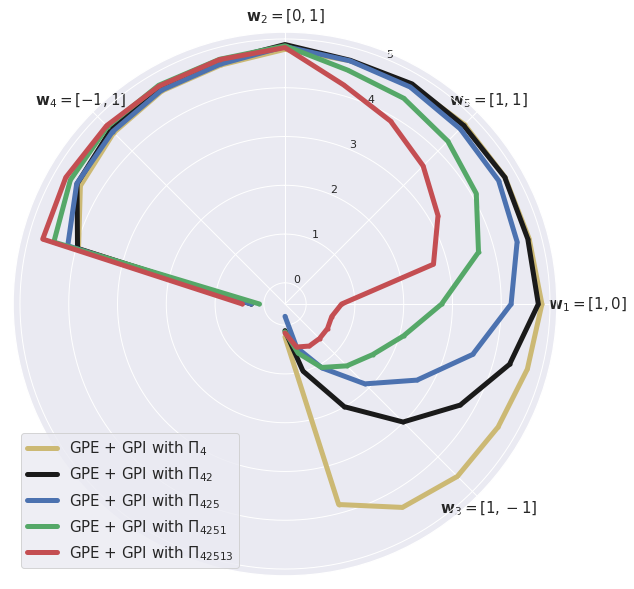

In [61]:
#@title Plot

use_polar = True
plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=use_polar)

policy_42513_mean_df = policy_42513_df.groupby("angle").mean()
ax.plot(
    policy_42513_mean_df.index,
    policy_42513_mean_df["return"],
    ".-",
    linewidth=5, color='y')

policy_4251_mean_df = policy_4251_df.groupby("angle").mean()
ax.plot(
    policy_4251_mean_df.index,
    policy_4251_mean_df["return"],
    ".-",
    linewidth=5, color='k')

policy_425_mean_df = policy_425_df.groupby("angle").mean()
ax.plot(
    policy_425_mean_df.index,
    policy_425_mean_df["return"],
    ".-",
    linewidth=5, color='b')

policy_42_mean_df = policy_42_df.groupby("angle").mean()
ax.plot(
    policy_42_mean_df.index,
    policy_42_mean_df["return"],
    ".-",
    linewidth=5, color='g')

policy_4_mean_df = policy_4_df.groupby("angle").mean()
ax.plot(
    policy_4_mean_df.index,
    policy_4_mean_df["return"],
    ".-",
    linewidth=5, color='r')

legend = ax.legend([
    r"GPE + GPI with $\Pi_{4}$",
    r"GPE + GPI with $\Pi_{42}$",
    r"GPE + GPI with $\Pi_{425}$",
    r"GPE + GPI with $\Pi_{4251}$",
    r"GPE + GPI with $\Pi_{42513}$",
    r"$Q$-learning",
    ],
                   fontsize="15",
                   loc="best")

ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

lines, labels = ax.set_thetagrids(
    (0, 45, 90, 135, 315),
    (r"$\mathbf{w}_2 = [0,1]$", r"$\mathbf{w}_5 = [1,1]$",
     r"$\qquad \mathbf{w}_1 = [1,0]$", r"$\mathbf{w}_3 = [1,-1]$",
     r"$\mathbf{w}_4 = [-1,1]$"),
    fontweight="bold",
    fontsize=15)

# Figure 6

To generate the q-learning results:
```
python3 ../run_dqn.py --num_episodes=20000 --report_every=100 --output_path=/tmp/fig6_dqn.csv
```

To generate the OK results:
```
python3 train_keybooard.py --num_pretrain_episodes=20000 --policy_weights_name=12 --export_path=/tmp/fig6_keyboard
python3 ../run_ok.py --num_episodes=20000 --report_every=100 --keyboard_path=/tmp/fig6_keyboard/tfhub --output_path=/tmp/fig6_ok.csv
```

To generate the results with fixed w:
```
# Make use of a pretrained keyboard. Change test_w to evaluate other policies such as [1,0] and [1,-1].
python3 run_true_w_fig6.py --num_episodes=1000 --keyboard_path=/tmp/fig6_keyboard/tfhub --test_w=1,1
```

Repeat the above steps for multiple runs. Below shows the results for 10 runs.

In [62]:
#@title Load Data

dqn_path = os.path.join(DATA_DIR, "fig6_dqn_{}.csv")
dqn_df = read_data(dqn_path, num_seeds=10)
dqn_df["method"] = "Q-Learning"
ok_path = os.path.join(DATA_DIR, "fig6_ok_{}.csv")
ok_df = read_data(ok_path, num_seeds=10)
ok_df["method"] = "GPE + GPI with varying w"
fig6_df = pd.concat([dqn_df, ok_df])

test_ws = [[1, 1], [1, 0], [1, -1]]
test_dfs = []
for test_w in test_ws:
  test_w_str = "|".join([str(x) for x in test_w])
  path = os.path.join(DATA_DIR, "fig6_true_w=" + test_w_str + "_{}.csv")
  test_dfs.append(read_data(path, num_seeds=10))

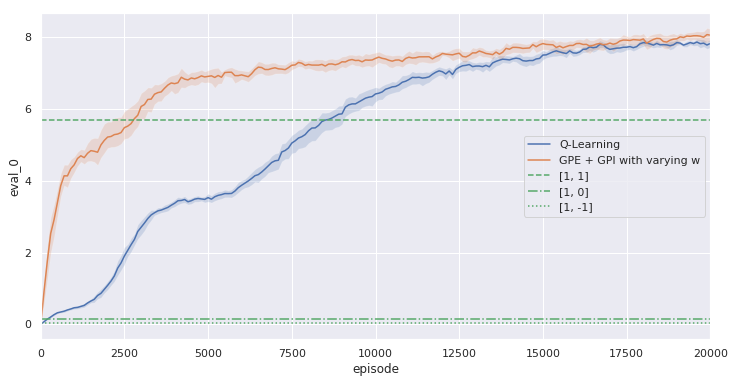

In [63]:
#@title Plot

fig, ax = plt.subplots(figsize=(12,6))
sns.tsplot(fig6_df, time="episode", unit="seed", value="eval_0", condition="method", ci=95, ax=ax)

ax.axhline(test_dfs[0]["return"].mean(), color='g', linestyle='--', label=test_ws[0])
ax.axhline(test_dfs[1]["return"].mean(), color='g', linestyle='-.', label=test_ws[1])
ax.axhline(test_dfs[2]["return"].mean(), color='g', linestyle=':', label=test_ws[2])

ax.legend();